## Generate Word Vectors
- [Neural Word Embedding as Implicit Matrix Factorization](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)
- [text8 data](http://mattmahoney.net/dc/text8.zip)
- [wordsim353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)
- [MEN Test collection](http://clic.cimec.unitn.it/~elia.bruni/MEN)

In [1]:
import numpy as np
import re
from scipy import sparse
import joblib
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
## parameters
WC_THR = 150
CC_THR = 6
window = 2
nnegative = 1.

In [4]:
corpus = open("data/text8").read()
pat = re.compile("\w+")
%time words = pat.findall(corpus)
print len(words)

CPU times: user 3.22 s, sys: 282 ms, total: 3.5 s
Wall time: 3.51 s
17005207


In [5]:
%time total_word_counter = Counter(words)

freq_words = set([w for w,c in total_word_counter.items() if c >= WC_THR])
print len(freq_words) *1. / len(total_word_counter), "% words are retained"


%time total_context_counter = Counter([tuple(words[i-window:i]+words[i+1:i+window+1]) for i in xrange(window, len(words)-window)])
freq_contexts = set([w for w,c in total_context_counter.items() if c >= CC_THR])
print len(freq_words) *1. / len(total_context_counter), "% contexts are retained"

CPU times: user 4.32 s, sys: 124 ms, total: 4.45 s
Wall time: 4.43 s
0.0348586195215 % words are retained
CPU times: user 19.1 s, sys: 1.4 s, total: 20.5 s
Wall time: 20.5 s
0.000595954339486 % contexts are retained


In [6]:
class Hasher(object):
    def __init__(self):
        self.N = 0
        self.data = {}
    def hash(self,item):
        if item not in self.data:
            self.data[item] = self.N
            self.N += 1
        return self.data[item]

In [7]:
def extract_wc_pairs(words,  freq_words, freq_contexts, window = 3,):
    wcpairs = []
    wordhasher = Hasher()
    contexthasher = Hasher()
    for i in xrange(window, len(words)-window):
        word, context = words[i], tuple(words[i-window:i]+words[i+1:i+window+1])
        if (word in freq_words) and (context in freq_contexts):
            hw, hc = wordhasher.hash(word), contexthasher.hash(context)
            wcpairs.append( (hw, hc) )
    return wordhasher, contexthasher, wcpairs

In [8]:
%time wordhasher, contexthasher, wcpairs = extract_wc_pairs(words, freq_words, freq_contexts, window=window)

CPU times: user 11.6 s, sys: 423 ms, total: 12 s
Wall time: 11.9 s


In [9]:
%time whs, chs = zip(*wcpairs)
whs, chs = np.asarray(whs), np.asarray(chs)
Mshape = (wordhasher.N, contexthasher.N)

CPU times: user 253 ms, sys: 52 ms, total: 305 ms
Wall time: 306 ms


In [10]:
%time wcounter = Counter(whs)
%time ccounter = Counter(chs)
D = len(wcpairs)
%time data = np.array([D*1./wcounter[wh]/ccounter[ch]/nnegative for wh,ch in wcpairs])

CPU times: user 437 ms, sys: 24.4 ms, total: 461 ms
Wall time: 415 ms
CPU times: user 412 ms, sys: 6.75 ms, total: 419 ms
Wall time: 407 ms
CPU times: user 1.05 s, sys: 6.69 ms, total: 1.06 s
Wall time: 1.06 s


In [11]:
%time M = sparse.coo_matrix((data, (whs, chs)), shape = Mshape, dtype=np.float32)
%time M = M.tocsr()
M.data = np.log(M.data)##
M[M<0.0] = 0.0
M.shape

CPU times: user 9.05 ms, sys: 1.83 ms, total: 10.9 ms
Wall time: 10.5 ms
CPU times: user 94.7 ms, sys: 5.45 ms, total: 100 ms
Wall time: 100 ms


(8371, 68197)

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, )

In [13]:
%time wvectors = svd.fit_transform(M)

CPU times: user 15.8 s, sys: 7.44 s, total: 23.2 s
Wall time: 1.82 s


In [14]:
from sklearn.preprocessing import normalize
normalized_wvectors = normalize(wvectors, axis = 1)

## check word-context matrix & word vectors

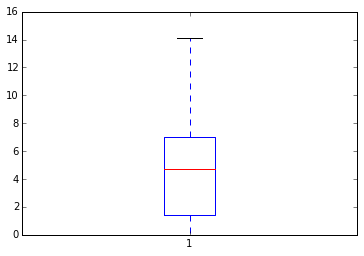

In [15]:
_ = plt.boxplot(M.data)

## save results

In [16]:
## inverse index
%time h2w = dict([(v,k) for k,v in wordhasher.data.items()])
%time h2c = dict([(v,k) for k,v in contexthasher.data.items()])

CPU times: user 17.8 ms, sys: 14.5 ms, total: 32.2 ms
Wall time: 10.6 ms
CPU times: user 66.5 ms, sys: 43.3 ms, total: 110 ms
Wall time: 36.6 ms


In [17]:


import h5py, cPickle

h5f = h5py.File("data/word_vectors.h5", "w")
%time h5f.create_dataset("data", data = wvectors)
h5f.close()

%time cPickle.dump(h2w, open("data/inverse_word_hash.pkl", "w"))
%time cPickle.dump(wordhasher.data, open("data/word_hash.pkl", "w"))
#%time cPickle.dump(h2c, open("data/inverse_context_hash.pkl", "w"))

CPU times: user 235 µs, sys: 3.96 ms, total: 4.2 ms
Wall time: 4.21 ms
CPU times: user 8.89 ms, sys: 517 µs, total: 9.4 ms
Wall time: 9.42 ms
CPU times: user 7.42 ms, sys: 319 µs, total: 7.73 ms
Wall time: 7.76 ms


## Evaluate Performance

In [18]:
import h5py, cPickle
h5f = h5py.File("data/word_vectors.h5", "r")
wvectors = h5f["data"][:]
h5f.close()

h2w = cPickle.load(open("data/inverse_word_hash.pkl"))
w2h = cPickle.load(open("data/word_hash.pkl"))

In [19]:
## use flann to find knn
import pyflann as pf
from scipy import stats

class NearestNeighbor(object):
    def __init__(self, k = 5, algorithm="kdtree", distance_type="euclidean"):
        pf.set_distance_type(distance_type)
        self.flann = pf.FLANN()
        self.k = k
        self.algorithm = "autotuned"#algorithm
        self.iterations = 100
    def train(self, X):
        self.X_ = X
    def nearest(self, X):
        min_index, dists = self.flann.nn(self.X_, X, self.k, 
                                         algorithm = self.algorithm, 
                                         iterations=self.iterations)
        return min_index, dists

### Nearest Neighbor

In [20]:
nn=NearestNeighbor()
nn.train(wvectors)
%time neighbors, dists =nn.nearest(wvectors)
for row in neighbors[1860:1870, :]:
    print [h2w[r] for r in row]

CPU times: user 1min 14s, sys: 2.47 s, total: 1min 16s
Wall time: 1min 16s
['divine', 'ionic', 'soup', 'farmer', 'twelve']
['periods', 'cooking', 'magazines', 'excess', 'digits']
['trinity', 'underworld', 'gospels', 'enlightenment', 'fluid']
['london', 'paris', 'berlin', 'vienna', 'chicago']
['blue', 'microwave', 'infrared', 'rural', 'gold']
['jews', 'greeks', 'monarchy', 'romans', 'children']
['manufacture', 'wake', 'exercise', 'coordination', 'delivery']
['soon', 'hardly', 'certainly', 'arguably', 'rather']
['outbreak', 'turn', 'dissolution', 'passage', 'completion']
['cold', 'trojan', 'korean', 'kosovo', 'cultural']


In [21]:
nn=NearestNeighbor()
nn.train(normalized_wvectors)
%time neighbors, dists =nn.nearest(wvectors)
for row in neighbors[1860:1870, :]:
    print [h2w[r] for r in row]

CPU times: user 1min 17s, sys: 2.69 s, total: 1min 20s
Wall time: 1min 19s
['divine', 'poor', 'blind', 'apostles', 'liver']
['periods', 'fruits', 'faces', 'wars', 'lords']
['trinity', 'liver', 'alps', 'gospels', 'chromosomes']
['london', 'berlin', 'paris', 'moscow', 'vienna']
['blue', 'microwave', 'northeastern', 'southwestern', 'southern']
['jews', 'scientists', 'volunteers', 'messages', 'shares']
['manufacture', 'wake', 'aftermath', 'eyes', 'course']
['soon', 'even', 'rapidly', 'barely', 'hardly']
['outbreak', 'arrival', 'turn', 'dissolution', 'completion']
['cold', 'anti', 'trojan', 'civil', 'korean']


In [22]:
wvectors.min(), wvectors.max(), normalized_wvectors.min(), normalized_wvectors.max()

(-164.06361974045404,
 149.53460156414531,
 -0.86207081908404937,
 0.93008508308530169)

In [23]:
dists.min(), dists.max()

(1.7628386362338768e-11, 35977.181700357425)

### Clustering

In [24]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=250, )
%time labels = kmeans.fit_predict(normalized_wvectors)

CPU times: user 6.37 s, sys: 6.5 s, total: 12.9 s
Wall time: 1.57 s


In [25]:
Counter(labels)

Counter({187: 156, 24: 137, 236: 130, 240: 122, 167: 120, 40: 116, 69: 111, 7: 109, 70: 106, 21: 105, 25: 100, 4: 98, 179: 98, 17: 96, 227: 96, 34: 92, 42: 92, 224: 91, 35: 88, 58: 85, 38: 83, 176: 77, 200: 77, 213: 77, 47: 75, 56: 75, 153: 75, 237: 75, 172: 73, 68: 71, 189: 71, 182: 69, 246: 69, 218: 68, 44: 67, 36: 64, 160: 62, 211: 60, 220: 59, 77: 58, 170: 58, 190: 58, 1: 57, 6: 57, 194: 57, 16: 55, 214: 55, 33: 54, 131: 54, 151: 54, 148: 53, 154: 53, 204: 53, 248: 52, 8: 50, 20: 50, 57: 50, 76: 50, 5: 49, 129: 48, 235: 48, 41: 47, 163: 47, 118: 46, 209: 46, 37: 45, 201: 45, 85: 44, 196: 44, 239: 44, 232: 43, 61: 42, 158: 42, 0: 41, 137: 41, 231: 41, 73: 40, 177: 40, 83: 39, 165: 39, 221: 39, 241: 39, 87: 38, 100: 38, 117: 37, 135: 37, 226: 37, 51: 36, 103: 36, 141: 36, 208: 36, 18: 35, 80: 35, 175: 35, 245: 35, 39: 34, 147: 34, 222: 34, 12: 33, 64: 33, 89: 33, 105: 33, 162: 33, 65: 32, 238: 32, 186: 31, 107: 30, 115: 30, 164: 30, 52: 29, 143: 29, 185: 29, 210: 29, 223: 29, 249: 29

In [26]:
ic = 155
for i in np.where(labels==ic)[0][:50]:
    print h2w[i]

montreal
detroit
calgary
dayton
denver
charlotte


In [27]:
ifrance, iparis, iuk, ilondon = w2h["king"], w2h["man"], w2h["queen"], w2h["woman"]

In [28]:
v = wvectors[ifrance] - wvectors[iparis] + wvectors[iuk]
u = wvectors[ilondon]

In [31]:
v = normalized_wvectors[ifrance] - normalized_wvectors[iparis] + normalized_wvectors[iuk]
u = normalized_wvectors[ilondon]

In [32]:
np.sqrt(np.sum((u-v)**2))

2.3405178365044135

In [33]:
dists[ilondon, :]

array([ 317.08672123,  319.21422333,  319.36409847,  321.88819338,
        322.26675642])

In [34]:
for row in neighbors[ilondon:ilondon+1, :]:
    print [h2w[r] for r in row]

['woman', 'man', 'person', 'player', 'circular']


##Observations
1. for the matrix factorization approach to work, filtering out low-freq words (and even contexts) is important, as otherwise the factorization will come up with a near-zero solution